# Homework1 - Regression

### SC24219070 朱越

## 一、导入库与数据预处理
    

#### ①程序结构参考了d2l课程的线性回归章节。
除了基本的torch库以外，还使用了pandas库用于文件读写，random库用于随机小批量抽取数据，matplotlib.pyplot库用于可视化。

In [1]:
import torch
import pandas
import random
import matplotlib.pyplot as plt

#### ②从csv文件（提供数据集的副本）中导入所有的数据，根据列分为features和labels两部分，并转换为tensor格式，便于后续运算。

打印了部分数据和张量尺寸，验证数据读取情况。

In [2]:
#①准备数据
data_file = r'datas/HW1.csv'
#end①

data = pandas.read_csv(data_file)
data = torch.tensor(data.to_numpy(), dtype=torch.float32)
inputs = data[:, 0:-1].clone()
outputs = data[:, -1].clone()

features = inputs.clone()
labels = outputs.clone()

print(f'features example: {features[1, 5:10]} \n')
print(f'labels example: {labels[3:8]} \n')
print(f'features shape: {features.shape} \n')
print(f'labels shape: {labels.shape} \n')

features example: tensor([  6.4210,  78.9000,   4.9671,   2.0000, 242.0000]) 

labels example: tensor([33.4000, 36.2000, 28.7000, 22.9000, 27.1000]) 

features shape: torch.Size([506, 13]) 

labels shape: torch.Size([506]) 



#### ③执行features_scaling，将feature的各个列求取均值和标准差，并执行标准化处理。

打印了部分scaling后的结果和scaling的情况。

In [3]:
def features_scaling(features, f_means, f_stds):
    for num in range(features.shape[1]):
        mean = torch.mean(features[:, num])
        std = torch.std(features[:, num])
        f_means[num] = mean
        f_stds[num] = std
        features[:, num] = (features[:, num] - mean) / std


features_means = torch.zeros(features.shape[1])
features_stds = torch.ones(features.shape[1])
features_scaling(features, features_means, features_stds)

print(f'features example: {features[1, 5:10]} \n means_example: {features_means[1]}, stds_example: {features_stds[1]} \n')
print(f'features_means shape: {features_means.shape} \n')
print(f'features_stds shape: {features_stds.shape} \n')

features example: tensor([ 0.1941,  0.3668,  0.5566, -0.8670, -0.9864]) 
 means_example: 11.363636016845703, stds_example: 23.322452545166016 

features_means shape: torch.Size([13]) 

features_stds shape: torch.Size([13]) 



## 二、构建模型和定义变量

#### ④定义回归所需的函数，包括小批量数据提取函数data_iter；线性回归模型linreg；均方损失squared_loss；梯度下降方法Adam。

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = features.shape[0]
    indices = torch.arange(0, num_examples)
    random.shuffle(indices)
    for num in range(0, num_examples, batch_size):
        batch_indices = indices[num: min(num + batch_size, num_examples)].clone().detach()
        yield features[batch_indices], labels[batch_indices]

def linreg(x, w, b):
    """线性回归模型"""
    return torch.matmul(x, w) + b

def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2

def Adam(params, lr, Momentum_terms, RMSProp_terms, beta_Momentum, beta_RMSProp, t, batch_size, eps):
    """Adam方法"""
    t += 1
    with torch.no_grad():
        for num, (param, Momentum_term, RMSProp_term) in enumerate(zip(params, Momentum_terms, RMSProp_terms)):
            RMSProp_terms[num] = beta_RMSProp * RMSProp_term + (1 - beta_RMSProp) * (param.grad / batch_size) ** 2
            Momentum_terms[num] = beta_Momentum * Momentum_term + (1 - beta_Momentum) * param.grad / batch_size
            Momentum_term = Momentum_terms[num] / (1 - beta_Momentum ** t)
            RMSProp_term = RMSProp_terms[num] / (1 - beta_RMSProp ** t)
            param -= (lr/torch.sqrt(RMSProp_term + eps)) * Momentum_term
            param.grad.zero_()

#### ⑤定义模型用到的所有参数，包括数据批次的大小、学习率、学习次数、模型参数等。

In [5]:
#②设置参数
batch_size = 10
lr = 0.1
num_epochs = 20
beta_Momentum = 0.9
beta_RMSProp = 0.99
#end②

#### ⑥定义回归过程中用到的一些变量，包括目标变量、中间变量、模型定义、计数变量等。

In [6]:
w = torch.normal(0, 1, size=(features.shape[1], 1), requires_grad=True, dtype=torch.float32)
b = torch.zeros(1, requires_grad=True, dtype=torch.float32)
losses = torch.zeros(num_epochs)

params = [w, b]
RMSProp_terms = [torch.zeros_like(param) for param in params]
Momentum_terms = [torch.zeros_like(param) for param in params]

net = linreg
loss = squared_loss
eps = 1e-8
t = 0

## 三、执行训练

### ⑦开始炼！

In [7]:
for epoch in range(num_epochs):
    for x, y in data_iter(batch_size, features, labels):
        l = loss(net(x, w, b), y)
        l.sum().backward()
        Adam(params, lr, Momentum_terms, RMSProp_terms, beta_Momentum, beta_RMSProp, t, batch_size, eps)

    with torch.no_grad():
        train_l = torch.sqrt(loss(net(features, w, b), labels)).mean()
        print(f'epoch {epoch + 1}, loss {float(train_l):f}')
        losses[epoch] = train_l

epoch 1, loss 14.739349
epoch 2, loss 11.233443
epoch 3, loss 8.538810
epoch 4, loss 6.432698
epoch 5, loss 4.781209
epoch 6, loss 3.767517
epoch 7, loss 3.410856
epoch 8, loss 3.279269
epoch 9, loss 3.380750
epoch 10, loss 3.553175
epoch 11, loss 3.213403
epoch 12, loss 3.222352
epoch 13, loss 3.603988
epoch 14, loss 3.336163
epoch 15, loss 3.328136
epoch 16, loss 3.293698
epoch 17, loss 3.315252
epoch 18, loss 3.490091
epoch 19, loss 3.460756
epoch 20, loss 3.387505


## 四、后处理与可视化

#### ⑧训练结束，将结果反变换恢复scaling前的情况，并打印结果和loss情况。

w: tensor([[-1.5313e-01,  1.5027e-02, -4.8189e-04,  3.2643e+00, -6.8677e+00,
          7.8993e+00, -6.7984e-03, -9.5546e-01,  2.7056e-01, -1.2340e-02,
         -6.5288e-01,  1.5206e-02, -2.9993e-01]], grad_fn=<ViewBackward0>)
b: tensor([-6.3572], grad_fn=<SubBackward0>)


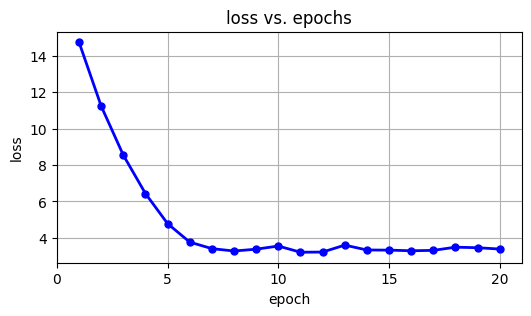

In [8]:
w = torch.div(w, features_stds.reshape(w.shape))
b = b - torch.sum(torch.mul(w, features_means.reshape(w.shape)))

print(f'w: {w.reshape(1, -1)}')
print(f'b: {b}')

epochs = torch.arange(1, num_epochs+1)
# 折线图
plt.figure(figsize=(6, 3))
plt.plot(epochs, losses, color='b', linestyle='-', marker='.', ms=10, mec='b', linewidth=2)
# 设置x、y轴
plt.grid()
plt.xlim(0, num_epochs+1)
plt.xticks(torch.arange(0, num_epochs+1, 5))
#plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("loss")
# 展示图片
plt.title('loss vs. epochs')
plt.show()

#### ⑨将所有的数据与模型预测的结果绘制散点图对比预测情况。

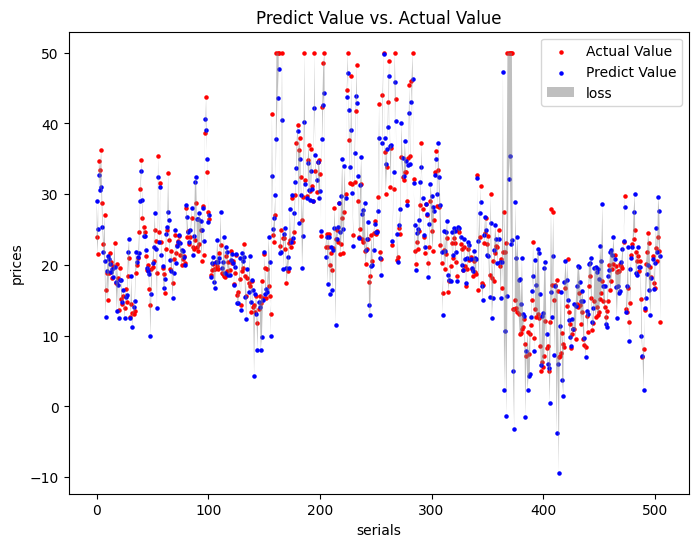

In [9]:
serials = torch.arange(outputs.shape[0])
results = net(inputs, w, b).detach().numpy()

# 创建图形
plt.figure(figsize=(8, 6))
# 绘制第一个数据集的散点图
plt.scatter(serials, outputs.reshape(serials.shape), label='Actual Value', color='red', s=5)
# 绘制第二个数据集的散点图
plt.scatter(serials, results.reshape(serials.shape), label='Predict Value', color='blue', s=5)
#填充误差区域
plt.fill_between(serials, outputs.reshape(serials.shape), results.reshape(serials.shape), facecolor='gray', alpha=0.5, label='loss')
# 添加图例
plt.legend()
# 设置标题和轴标签
plt.xlabel('serials')
plt.ylabel('prices')
# 显示图形
plt.title('Predict Value vs. Actual Value')
plt.show()

## 五、优化

由上面的结果可以看出，loss最终保持在3.3左右无法继续下降，而预测结果在部分区域内也与实际情况误差较大。
猜想可能是某些feature引入了过多噪声，先绘制各feature与label的关系图：

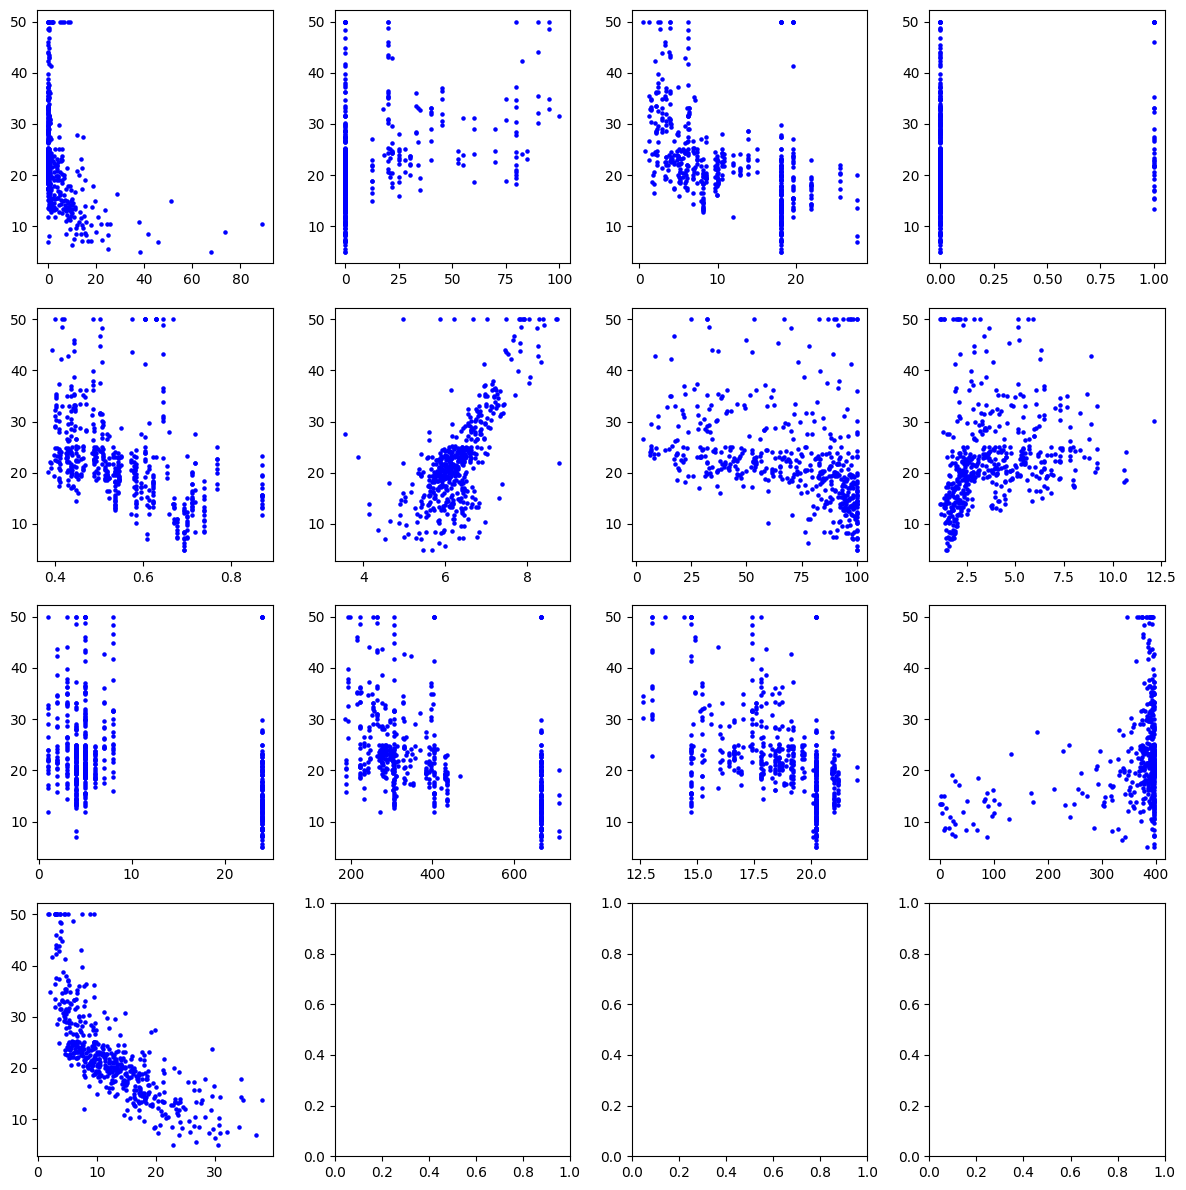

In [10]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for num in range(inputs.shape[1]):
    axs[num//4, num%4].scatter(inputs[:, num], outputs.reshape(serials.shape), color='blue', s=5)
plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()

可以看出并不是各项feature都与label具有显著相关性，因此可以计算各feature与label的皮尔逊相关系数：

In [11]:
# 将 features 和 labels 拼接在一起
data = torch.cat([inputs, outputs.reshape([-1, 1])], dim=1)
# 计算相关系数矩阵
correlation_matrix = torch.corrcoef(data.T)
# 提取 features 和 labels 之间的相关性
correlations = correlation_matrix[:-1, -1]
print(f'feature vs. label: {correlations} \n')

feature vs. label: tensor([-0.3883,  0.3604, -0.4837,  0.1753, -0.4273,  0.6954, -0.3770,  0.2499,
        -0.3816, -0.4685, -0.5078,  0.3335, -0.7377]) 



将相关性阈值设置为0.4，重新从inputs中提取数据，再一次执行训练：

w: tensor([[-0.0387, -3.6634,  7.1441, -0.0089, -0.7914, -0.3439]],
       grad_fn=<ViewBackward0>)
b: tensor([2.5676], grad_fn=<SubBackward0>)


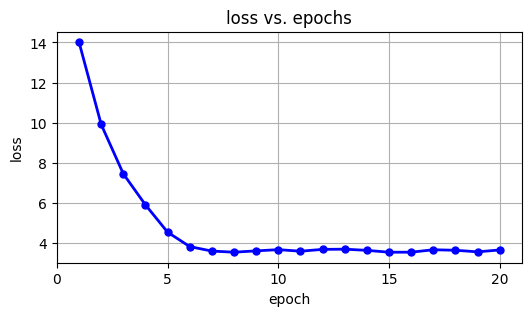

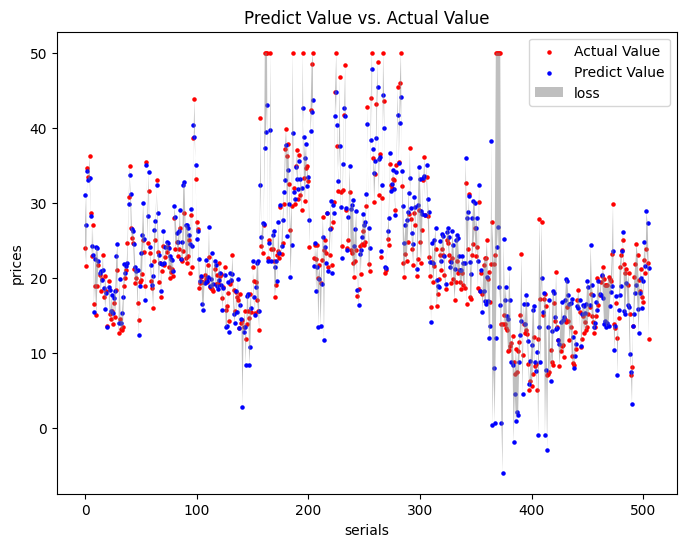

In [12]:
features = torch.tensor([])
for num in range(correlations.shape[0]):
    if torch.abs(correlations[num]) >= 0.4:
        features = torch.cat((features, inputs[:, num].unsqueeze(1)), dim=1)
inputs_corr = features.clone()

features_means = torch.zeros(features.shape[1])
features_stds = torch.ones(features.shape[1])
features_scaling(features, features_means, features_stds)

lr = 0.1
num_epochs = 20

w = torch.normal(0, 1, size=(features.shape[1], 1), requires_grad=True, dtype=torch.float32)
b = torch.zeros(1, requires_grad=True, dtype=torch.float32)
losses = torch.zeros(num_epochs)

params = [w, b]
RMSProp_terms = [torch.zeros_like(param) for param in params]
Momentum_terms = [torch.zeros_like(param) for param in params]

t = 0
for epoch in range(num_epochs):
    for x, y in data_iter(batch_size, features, labels):
        l = loss(net(x, w, b), y)
        l.sum().backward()
        Adam(params, lr, Momentum_terms, RMSProp_terms, beta_Momentum, beta_RMSProp, t, batch_size, eps)

    with torch.no_grad():
        train_l = torch.sqrt(loss(net(features, w, b), labels)).mean()
        losses[epoch] = train_l

w = torch.div(w, features_stds.reshape(w.shape))
b = b - torch.sum(torch.mul(w, features_means.reshape(w.shape)))

print(f'w: {w.reshape(1, -1)}')
print(f'b: {b}')

epochs = torch.arange(1, num_epochs+1)
plt.figure(figsize=(6, 3))
plt.plot(epochs, losses, color='b', linestyle='-', marker='.', ms=10, mec='b', linewidth=2)
plt.grid()
plt.xlim(0, num_epochs+1)
plt.xticks(torch.arange(0, num_epochs+1, 5))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('loss vs. epochs')
plt.show()

serials = torch.arange(outputs.shape[0])
results = net(inputs_corr, w, b).detach().numpy()
plt.figure(figsize=(8, 6))
plt.scatter(serials, outputs.reshape(serials.shape), label='Actual Value', color='red', s=5)
plt.scatter(serials, results.reshape(serials.shape), label='Predict Value', color='blue', s=5)
plt.fill_between(serials, outputs.reshape(serials.shape), results.reshape(serials.shape), facecolor='gray', alpha=0.5, label='loss')
plt.legend()
plt.xlabel('serials')
plt.ylabel('prices')
plt.title('Predict Value vs. Actual Value')
plt.show()

好吧其实并没有下降多少，而且我偷偷问了一下DeepSeek，据说线性回归模型的方均根Loss一般就在3-5之间，3.3已经很不错了！

## 六、总结与反思

本次实验的大部分工作量贡献给了研究Python语法、学习Pytorch函数以及琢磨matplotlib绘图上，看到训练结果的时候还蛮有成就感的 :)

反思在于我在这次作业中太执着于每条语句的细节，其实大部分内容利用torch库的封装函数可以更简洁（比如模型定义、损失函数定义、梯度下降方法、训练过程等），导致我对于抽象层面的神经网络理解还不透彻，以后的作业应该更加注重模型构建的逻辑，避免在细枝末节的计算中太过纠结。